In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [31]:
df = pd.read_csv('Cleaned Datasets/US_Full_Quarterly.csv')
# Extract data for USA and Japan
USA = df[df['Country'] == "UNITED STATES"].reset_index()
JAPAN = df[df['Country'] == "JAPAN"].reset_index()
# Only use GDP data
USA = USA[['Country', 'Year', 'GDP']]
JAPAN = JAPAN[['Country', 'Year', 'GDP']]

FileNotFoundError: [Errno 2] No such file or directory: 'Cleaned Datasets/US_Full_Quarterly.csv'

# Classical Decomposition - Multiplicative model

We begin with a preliminary analysis of GDP trends using a classical decompoisition model. Since GDP generally grows exponentially (see figure GDPFIGURE), we will take the natural log of GDP to get our model into the following additive form:

$$ log(GDP)_t = T_t + S_t + R_t $$

In this model, $T_t$ represents the trend, $S_t$ represents a seasonal component, and $R_t$ is the remainder. 

Figure GDPFIGURE shows the GDP trends of the United States:

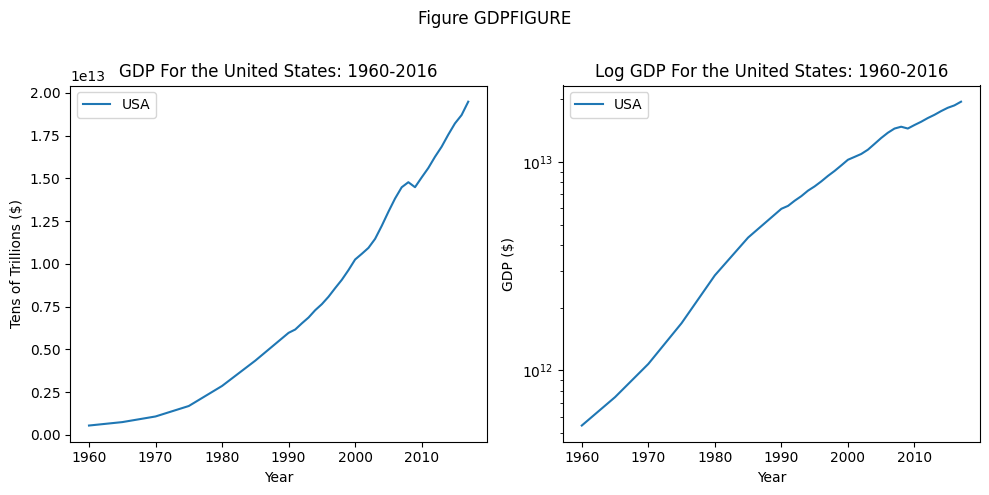

In [29]:
# Plot initial results
fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.gca().yaxis.get_offset_text().set_visible(False)
USA.plot(x="Year", y="GDP", ax=axs[0], label="USA")
#JAPAN.plot(x="Year", y="GDP", ax=axs[0], label="Japan")
axs[0].set_title("GDP For the United States: 1960-2016")
axs[0].set_ylabel("Tens of Trillions ($)")

# Plot the logged models
axs[1].set_yscale("log")
USA.plot(x="Year", y="GDP", ax=axs[1], label="USA")
#JAPAN.plot(x="Year", y="GDP", ax=axs[1], label="Japan")
axs[1].set_title("Log GDP For the United States: 1960-2016")
axs[1].set_ylabel("GDP ($)")
plt.gca().yaxis.get_offset_text().set_visible(False)
plt.suptitle("Figure GDPFIGURE")
plt.tight_layout()
plt.show()

These graphs indicate that GDP grows exponentially, especially in the case of the United States. TODO: IS THERE RESEARCH WE CAN CITE THAT SUPPORTS THIS? I'M PRETTY SURE EVERYONE AGREES THAT GDP IS EXPONENTIAL. The log GDP graph is approximately linear, especially with the United States, indicating that the trend $T_t$ should be of the form $T_t = \beta_1 t + \beta_0 $. The seasonal component $S_t$ doesn't appear significant in this graph, so we will assume $ S_t = 0 $. 

Since there isn't a seasonality aspect to this data, a moving averages model will not help us estimate the trend $T_t$. However, running a simple linear regression on the data can help us estimate the parameters $ \hat{\beta_0}, \hat{\beta_1}$. Using these parameters, we will difference the data in our model to see whether the differenced data is covariance-stationary; if it is, we can be confident that our model adequately explains the variation in the data.

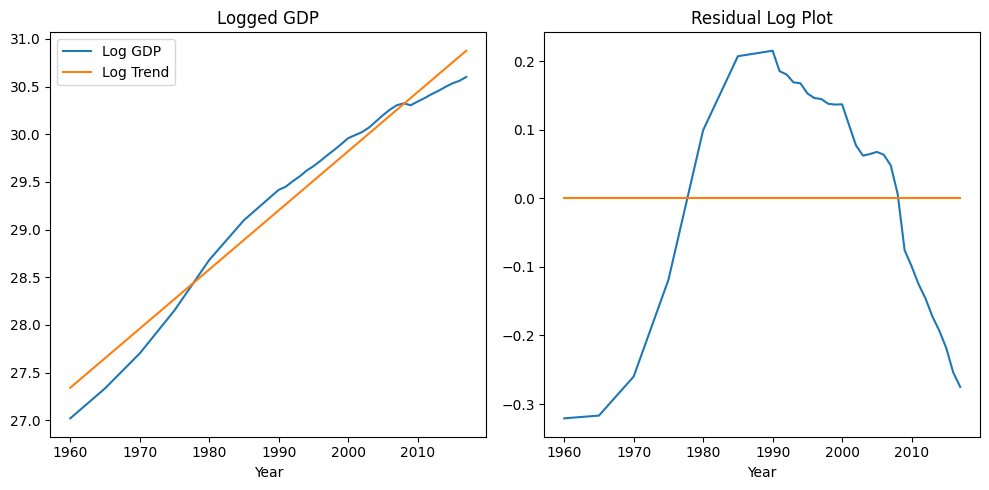

beta_0: -94.1619
beta_1: 0.062


In [25]:
def FitTrendAndPlot(df):
    '''df - the dataframe of the country data'''
    df['log_GDP'] = np.log(df['GDP'])
    y = df['log_GDP']
    X = sm.add_constant(df['Year'])

    model = sm.OLS(y, X).fit()
    modelPrediction = model.predict(X)

    # Plot the results, both logged and the original
    fig, axs = plt.subplots(1,2, figsize=(10,5))

    df.plot(y='log_GDP', x='Year', ax=axs[0], label="Log GDP")
    axs[0].plot(df['Year'], modelPrediction, label="Log Trend")
    axs[0].set_title(f"Logged GDP")
    axs[0].legend()

    # De-trend the plots
    df['detrended_log_GDP'] = df['log_GDP'] - modelPrediction
    df.plot(y='detrended_log_GDP', x='Year', ax=axs[1], legend=False)
    axs[1].plot(df['Year'], np.zeros_like(df['Year']))
    axs[1].set_title("Residual Log Plot")
    
    plt.tight_layout()
    plt.show()

    return model

modelUSA = FitTrendAndPlot(USA)
print(f"beta_0: {modelUSA.params[0].round(4)}")
print(f"beta_1: {modelUSA.params[1].round(4)}")

In [30]:
#modelJapan = FitTrendAndPlot(JAPAN)
#print(f"beta_0: {modelJapan.params[0].round(4)}")
#print(f"beta_1: {modelJapan.params[1].round(4)}")

The Residual plots represents the average log_GDP growth. Both the United States and Japan experienced smaller growth than normal growth up until the mid-1970s, overperformed until the mid-2000s, then began to underperform again. It is clear that the residual plots for both the United States and Japan are not-covariance stationary: the expected values are dependent on time.

This implies that the multiplicative decomposition model is inadequate to model GDP growth. There is clearly more significant variation that is not explained by the model. As such, we will turn our focus to ARMA models and Kalman filtering to better understand GDP trends.
